### Notes:
**this notebook is the same process with training.py on root folder. On that training.py is a modular version of this project, beside this is the experiment version.**

In [1]:
import pandas as pd
import numpy as np
import re
from tqdm import tqdm
from imblearn.over_sampling import RandomOverSampler
from nlp_id import StopWord, Lemmatizer
from gensim.utils import tokenize
import torch
import torch.nn.functional as F
from torch import nn
from torch.utils.data import Dataset, DataLoader, RandomSampler
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import matplotlib.style as style
from gensim.models import Word2Vec
from jcopdl.callback import Callback

# Import Data

In [2]:
# Import Dataset
df = pd.read_csv("../data/abstract_dataset.csv")

In [3]:
df.head()

,abstract,study_program
0,Tujuan penelitian ini adalah untuk mengetahui ...,Manajemen
1,"Skripsi ini disusun oleh Andri Tanjung, NRP 02...",Manajemen
2,Setiap organisasi didirikan untuk mencapai tuj...,Akuntansi
3,Penelitian ini bertujuan untuk mengetahui peng...,Manajemen
4,Penelitian ini bertujuan untuk mengetahui peng...,Akuntansi


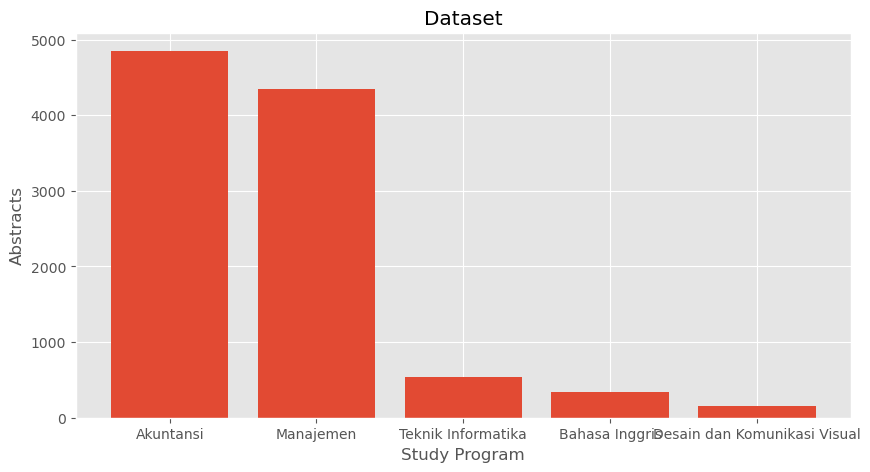

In [4]:
style.use(style.available[9])
plt.figure(figsize=(10, 5))
plt.bar(list(df.study_program.value_counts().keys()), df.study_program.value_counts().values)
plt.title("Dataset")
plt.xlabel("Study Program")
plt.ylabel("Abstracts")
plt.show()

# Preprocessing

### Encode Labels

In [5]:
studyprogram_encoder = {
            "Akuntansi": 0, 
            "Manajemen": 1,
            "Teknik Informatika": 2,
            "Bahasa Inggris": 3,
            "Desain dan Komunikasi Visual": 4
        }

for label in df['study_program']:
    label = studyprogram_encoder[label]

for i in range(len(df)):
    df.at[i, 'study_program'] = studyprogram_encoder[df.at[i, 'study_program']]

In [6]:
print(f"Encode Result Sample: {df.study_program.values[:10]}")

Encode Result Sample: [1 1 0 1 0 1 0 0 0 1]


### split dataset

In [7]:
    # X = df['abstract']  |  y = df['study_program']
X_train, X_test, y_train, y_test = train_test_split(df['abstract'].values, df['study_program'].values, test_size=0.25, stratify=df['study_program'], shuffle=True, random_state=42, train_size=0.75)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((7667,), (2556,), (7667,), (2556,))

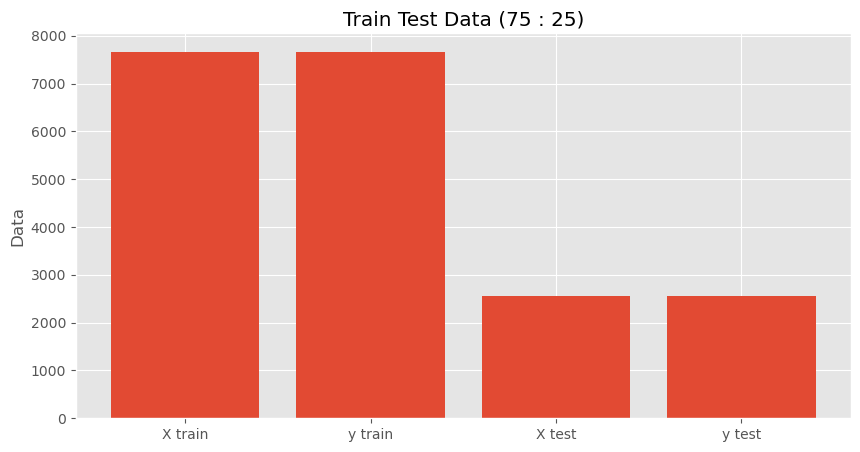

In [8]:
plt.figure(figsize=(10, 5))
plt.bar(["X train", "y train", "X test", "y test"], [len(X_train), len(y_train), len(X_test), len(y_test)])
plt.title("Train Test Data (75 : 25)")
plt.ylabel("Data")
plt.show()

### Oversampling on data train (Imbalance Data Handling)

In [9]:
ros = RandomOverSampler()
X_train, y_train = ros.fit_resample(X_train.reshape(-1, 1), y_train.astype('int'))

In [10]:
# return the X_train shape
X_train = X_train.squeeze()
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((18180,), (2556,), (18180,), (2556,))

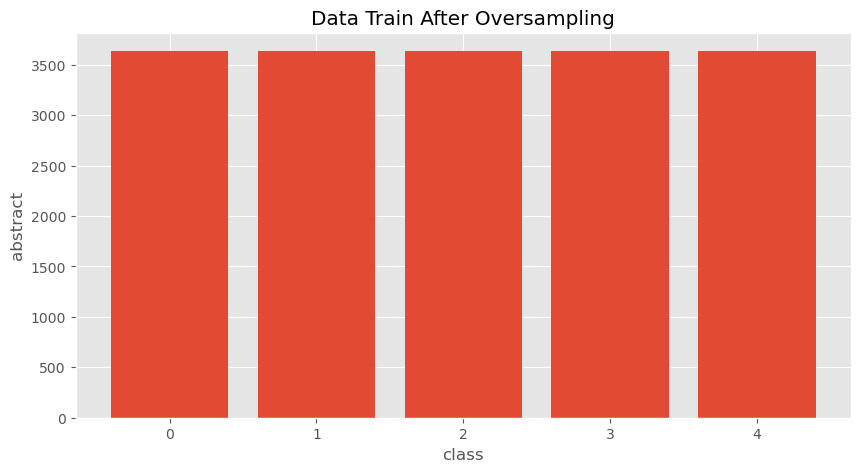

In [11]:
plt.figure(figsize=(10, 5))
plt.bar(list(df.study_program.value_counts().keys()), pd.Series(y_train).value_counts().values)
plt.title("Data Train After Oversampling")
plt.xlabel("class")
plt.ylabel("abstract")
plt.show()

### Clean Abstract Text
Note: **either X_train or X_test need to be cleaned**

In [12]:
# create function for perform cleaning each text
def text_cleaning(text):
        result = text.lower() # apply lowercas
        result = result.replace('-', ' ') # get rid of punctuations
        result = result.replace('+', ' ')
        result = result.replace('..', ' ')
        result = result.replace('.', ' ')
        result = result.replace(',', ' ')
        result = result.replace('\n', ' ') # get rid of new line
        result = re.findall('[a-z\s]', result, flags=re.UNICODE) # only use text character (a-z) and space
        result = "".join(result)
        final = " ".join(result.split())
        
        return final    # clean text

In [13]:
clean_text_fn = np.vectorize(text_cleaning)
X_train = clean_text_fn(X_train)
X_test = clean_text_fn(X_test)

In [14]:
print(f"X_train shape: {X_train.shape}")
print(f"X_test shape: {X_test.shape}")

X_train shape: (18180,)
X_test shape: (2556,)


In [15]:
print(f"Sample result: {X_train[0]}")

Sample result: the illuminator artwork school adalah institusi underground pertama di indonesia yang akan memberikan kursus membuat artwork mereka mengonsep metode street college dimana materi pelajaran diberikan secara learning by doing dengan metode ini siswa dituntut belajar dan bekerja effektif dengan cara yang kreatif sehingga bisa menjadi seorang artworker yang mampu menghasilkan karya yang gemilang selain itu siswa juga akan dijadikan seorang artworker yang imaginatif berwawasan luas dan siap bersaing


### Removing Stopwords

In [16]:
stopword = StopWord()
def remove_stopwords(text):
    return stopword.remove_stopword(text=text)

In [17]:
sw_fn = np.vectorize(remove_stopwords)
X_train = sw_fn(X_train)
X_test = sw_fn(X_test)

In [18]:
print(f"X_train shape: {X_train.shape}")
print(f"X_test shape: {X_test.shape}")
print(f"Sample result: {X_train[0]}")

X_train shape: (18180,)
X_test shape: (2556,)
Sample result: the illuminator artwork school institusi underground indonesia kursus artwork mengonsep metode street college materi pelajaran learning by doing metode siswa dituntut belajar effektif kreatif artworker menghasilkan karya gemilang siswa dijadikan artworker imaginatif berwawasan luas bersaing


### Lematization

In [19]:
X_train.shape, X_test.shape

((18180,), (2556,))

In [20]:
X_train_lemmatized = []
X_test_lemmatized = []
lemmatizer = Lemmatizer()

for text_train in tqdm(X_train, desc="X_train", total=X_train.size):
    X_train_lemmatized.append(lemmatizer.lemmatize(text_train))

for text_test in tqdm(X_test, desc="X_test", total=X_test.size):
    X_test_lemmatized.append(lemmatizer.lemmatize(text_test))

X_train = np.array(X_train_lemmatized)
X_test = np.array(X_test_lemmatized)

X_test: 100%|██████████| 2556/2556 [00:00<00:00, 6214.36it/s]


In [21]:
print(f"X_train Shape: {X_train.shape} | X_test Shape: {X_test.shape}")
print(f"Sample X_train_lemmatized: {X_train_lemmatized[0]}")
print(f"Sample X_test_lemmatized: {X_test_lemmatized[0]}")

X_train Shape: (18180,) | X_test Shape: (2556,)
Sample X_train_lemmatized: the illuminator artwork school institusi underground indonesia kursus artwork konsep metode street college materi ajar learning by doing metode siswa tuntut ajar effektif kreatif artworker hasil karya gemilang siswa jadi artworker imaginatif wawas luas saing
Sample X_test_lemmatized: teliti tuju pengaruh karakteristik kelola uang sekolah transparansi efektivitas kelola uang sekolah dasar unggul nasywa kabupaten bandung barat karakteristik pengelolan uang liput strategic planning strategic manajemen strategic thinking padu konsep transparansi liput pendayagunaan jalur komunikasi langsung langsung bijak informasi prosedur adu informasi public atur jamin hak publik informasi sekolah fasilitas database sarana informasi komunikasi hasil efektivitas kelola uang sekolah sesuai rencana anggar dapat belanja sekolah rapbs teliti data primer kumpul data kuesioner responden pandang relevan masalah identifikasi metode analis

### Tokenization

In [22]:
X_train.shape, X_test.shape

((18180,), (2556,))

In [23]:
X_train_tokenized = []
X_test_tokenized = []

for text_train in tqdm(X_train, desc="X_train", total=len(X_train)):
    X_train_tokenized.append(list(tokenize(text_train)))

for text_test in tqdm(X_test, desc="X_train", total=len(X_test)):
    X_test_tokenized.append(list(tokenize(text_test)))

X_train = X_train_tokenized
X_test = X_test_tokenized

X_train: 100%|██████████| 2556/2556 [00:00<00:00, 13481.28it/s]


In [24]:
print(f"X_train_temp: {len(X_train_tokenized)} | X_test_temp: {len(X_test_tokenized)}")

X_train_temp: 18180 | X_test_temp: 2556


### Vectorization (Transform)

In [25]:
# define Word2Vec model
w2v_model = Word2Vec.load('../core/w2v_model/w2v_model.w2v')

In [26]:
X_train_vectorized = []
X_test_vectorized = []

# X_train
for train_tokens in X_train:
    tokens_vector = []
    for token in train_tokens:
        if token in w2v_model.wv:
            tokens_vector.append(w2v_model.wv.get_vector(token))
    X_train_vectorized.append(tokens_vector)

# X_test
for test_tokens in X_test:
    tokens_vector = []
    for token in test_tokens:
        if token in w2v_model.wv:
            tokens_vector.append(w2v_model.wv.get_vector(token))
    X_test_vectorized.append(tokens_vector)

X_train = X_train_vectorized
X_test = X_test_vectorized

In [27]:
len(X_train[0][0])

128

### Padding

In [28]:
X_train_padded = []
X_test_padded = []

for tokens in tqdm(X_train, desc="X_train", total=len(X_train)):
    tokens = torch.Tensor(tokens)
    if len(tokens) > 100:
        tokens = tokens[:100]
    elif len(tokens) < 100:
        padd_needed = 100 - len(tokens)
        tokens = F.pad(tokens, (0, 0, 0, padd_needed), mode='constant', value=0)
    # change to np.array()
    tokens = np.array(tokens)
    X_train_padded.append(tokens)

for tokens in tqdm(X_test, desc="X_test", total=len(X_test)):
    tokens = torch.Tensor(tokens)
    if len(tokens) > 100:
        tokens = tokens[:100]
    elif len(tokens) < 100:
        padd_needed = 100 - len(tokens)
        tokens = F.pad(tokens, (0, 0, 0, padd_needed), mode='constant', value=0)
    # change to np.array()
    tokens = np.array(tokens)
    X_test_padded.append(tokens)

X_train = np.array(X_train_padded)
X_test = np.array(X_test_padded)


X_train:   0%|          | 0/18180 [00:00<?, ?it/s]/var/folders/px/q40ddk213vb6_1wwm1rtd27h0000gp/T/ipykernel_58987/2895611816.py:5: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  /Users/runner/miniforge3/conda-bld/pytorch-recipe_1664817727684/work/torch/csrc/utils/tensor_new.cpp:204.)
  tokens = torch.Tensor(tokens)
X_test: 100%|██████████| 2556/2556 [00:02<00:00, 1254.33it/s]


In [29]:
X_train.shape, X_test.shape

((18180, 100, 128), (2556, 100, 128))

# Setup custom Dataset class

In [99]:
class TextDataset(Dataset):
    def __init__(self, texts, labels) -> None:
        super().__init__()
        self.texts = texts
        self.labels = labels

    def __len__(self):
        return len(self.texts)
    
    def __getitem__(self, index):
        return self.texts[index], self.labels[index]

In [109]:
train_set = TextDataset(X_train, y_train)
test_set = TextDataset(X_test, y_test)

train_loader = DataLoader(train_set, batch_size=64, shuffle=True)
test_loader = DataLoader(test_set, batch_size=64)

# Modeling Setup

### Define nn.Module custom class

In [110]:
class LSTMClassifier(nn.Module):
    def __init__(self) -> None:
        super(LSTMClassifier, self).__init__()
        self.lstm = nn.LSTM(input_size=128, hidden_size=128, num_layers=2, batch_first=True)

        self.fc = nn.Sequential(
            nn.Linear(in_features=128, out_features=64),
            nn.ReLU(),
            nn.Dropout(0.2),

            nn.Linear(in_features=64, out_features=32),
            nn.ReLU(),
            nn.Dropout(0.2),

            nn.Linear(in_features=32, out_features=5),
            nn.LogSoftmax(dim=1)
        )

    def forward(self, x):
        # initiate hidden state and cell state
        # hidden state (h0) and cell state initial (c0) = (number_layer = 2, batch_size (x.size) = 64, hidden_size = 128)
        h0 = torch.zeros(2, len(x), 128)
        c0 = torch.zeros(2, len(x), 128)

        # forward to lstm
        output, (hn, cn) = self.lstm(x, (h0, c0))

        # flatten
        output = output[:, -1, :]

        # forward to fc (fully connected)
        output = self.fc(output)

        return output

### define model, criterion, optimizer, callback

In [111]:
model = LSTMClassifier()
crietrion = nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(params=model.parameters(), lr=0.0001)
callback = Callback(model = model, outdir='log')

# Modeling

In [112]:
while True:
    # Training Loop
    model.train()
    train_cost = 0
    for X, y in tqdm(train_loader, desc="Train"):
        # forward propagation
        output = model(X)

        # calculate loss
        loss = crietrion(output, y)

        # back propagation
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

        train_cost += loss.item() * X.shape[0]

    train_cost = train_cost / len(train_set)

    # Test Loop
    with torch.no_grad():
        model.eval()
        test_cost = 0

        for X, y in tqdm(test_loader, desc="Test"):
            # forward propagation
            output = model(X)

            # calculation loss
            loss = crietrion(output, y)
            test_cost += loss.item() * X.shape[0]

        test_cost = test_cost / len(test_set)
    
    # Callback
        # logging
    callback.log(train_cost=train_cost, test_cost=test_cost)
        # checkpoint
    callback.save_checkpoint()
        # Runtime Plotting
    callback.cost_runtime_plotting()
        # Early Stopping
    stoper = callback.early_stopping(model=model, monitor="test_cost")
    if stoper:
        callback.plot_cost()
        break

Train: 100%|██████████| 285/285 [01:39<00:00,  2.85it/s]


cost_train per epoch: 1.351164600348184


Test: 100%|██████████| 40/40 [00:05<00:00,  6.99it/s]

cost_test per epoch 0.6850278945596006


In [98]:
# model.train()
# cost = 0

# X, y = next(iter(train_loader))
# # forward propagation
# output = model(X)
# # calculate loss
# loss = crietrion(output, y)
# # back propagation
# loss.backward()
# optimizer.step()
# optimizer.zero_grad()
# cost += loss.item() * X.shape[0]
# print(f"Train cost: {cost}")